## Task 1
#### Plain SVM

train: 11.983612298965454 s predict: 4.485473871231079 s
Accuracy = 96.49870322341609 % ( 36463 / 37786 )
F1 = 0.9264083723001558
ROC:


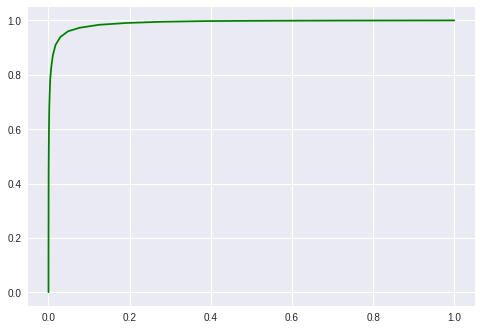

In [2]:
from utility.core import *
import seaborn
import matplotlib.pyplot as plt

if (__name__ == "__main__") :
    data = list(readNtranslate("./data/train.txt")) + list(readNtranslate("./data/test.txt"))
    p_vals = trainNpredict(data)

    print('train:',p_vals[-1][0],'s','predict:',p_vals[-1][1],'s')
    p_vals.pop()
    p_vals.pop()
    
    threshold = [-8,-4,4,8]		

    for i in range(-20,20,2) :
        threshold.append(i / 10)

    threshold.sort()
    
    result_label = list(map(getLabel,p_vals,[0] * len(p_vals))) 
    Evaluation(result_label,data[2])

    print("ROC:")
    x = []
    y = []
    for i in range(len(threshold)):
        result_label = list(map(getLabel,p_vals,[threshold[i]] * len(p_vals))) 
        now_y,now_x = Evaluation(result_label,data[2],False)  
        x.append(now_x)
        y.append(now_y)
    plt.plot(x,y,linestyle='-',color='green',marker='x')
    plt.show()

## Task 2
#### Random Shuffle SVM + Min Max Modular Network


process: 0 train: 6.859338760375977 s predict: 4.978607654571533 s
process: 1 train: 6.841753959655762 s predict: 5.012355804443359 s
process: 2 train: 6.880698204040527 s predict: 4.7549755573272705 s
process: 3 train: 6.794092416763306 s predict: 4.744239330291748 s
Accuracy = 96.33462128830784 % ( 36401 / 37786 )
F1 = 0.9227247347850364
ROC:


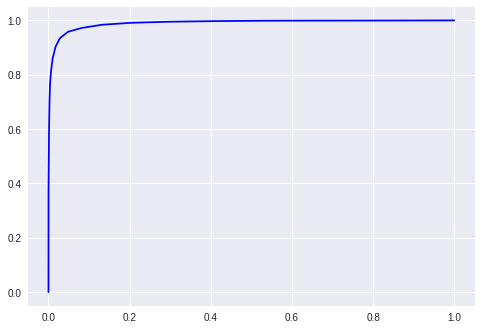

In [3]:
from liblinearutil import *
from functools import reduce
from utility.core import *
from multiprocessing import Pool as ThreadPool

if __name__ == '__main__': 
    label,features = readNtranslate("./data/train.txt")
    test_label,test_features = readNtranslate("./data/test.txt")

    label,features = random_shuffle(label,features)

    train_label = []
    train_features = []

    length = len(label)

    group = 4
    half = group // 2
    group_size = length // group
    pair = half * half

    data = []

    for i in range(group) :
        train_label.append(label[i * group_size : (i + 1) * group_size])
        train_features.append(features[i * group_size :(i + 1) * group_size])

    for i in range(half) :
        for j in range(half) :

            data.append([train_label[i] + train_label[j + half], 
                        train_features[i] + train_features[j + half], 
                        test_label,
                        test_features])

    pool = ThreadPool(4)
    p_vals = pool.map(trainNpredict,data)

    pool.close()
    pool.join()

    for i in range(half * half):
        print('process:',i,'train:',p_vals[i][-1][0],'s','predict:',p_vals[i][-1][1],'s')
        p_vals[i].pop()
        p_vals[i].pop()

    result_label = minmax(half,half,p_vals,0)
    Evaluation(result_label,test_label)

    threshold = [-8,-4,4,8]
    for i in range(-20,20,2) :
        threshold.append(i / 10)
    threshold.sort()

    print("ROC:")
    x = []
    y = []
    for i in range(len(threshold)):
        result_label = minmax(half,half,p_vals,threshold[i])
        now_y,now_x = Evaluation(result_label,test_label,False)
        x.append(now_x)
        y.append(now_y)
    plt.plot(x,y,linestyle='-',color='blue',marker='x')
    plt.show()

## Task 3
#### Classified by Knowledge SVM + Min Max Modular Network

process 0 train: 18.51394772529602 s predict: 61.00024890899658 s
process 1 train: 18.044525384902954 s predict: 63.35466527938843 s
process 2 train: 20.9883713722229 s predict: 62.15897607803345 s
process 3 train: 21.363049745559692 s predict: 61.16891646385193 s
Accuracy = 96.79246281691631 % ( 36574 / 37786 )
F1 = 0.9327861579414375
ROC:


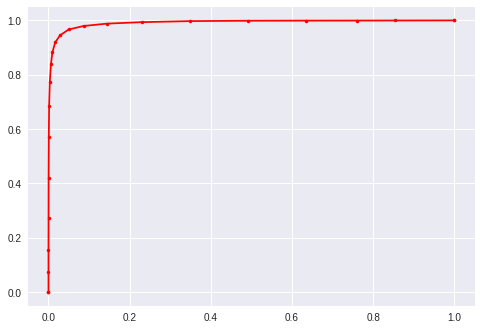

In [4]:
from liblinearutil import *
from functools import reduce
import time
from utility.core import *
from multiprocessing import Pool as ThreadPool
import matplotlib.pyplot as plt

if __name__ == '__main__': 

    train_label,train_features = read_problem("./data/train.txt")
    train_label = list(map(relabel,train_label))

    test_label,test_features = read_problem("./data/test.txt")
    digit_label = list(map(relabel,test_label))
    test_label = list(map(translate,test_label))
    test_len = len(test_label)

    segment = []
    l = 0
    total = len(train_label)
    for i in range(total) :
        if (i == total - 1 or train_label[i] != train_label[i + 1]) :
            segment.append((l,i,train_label[i]))
            l = i

    train_label = list(map(translate,train_label))

    pos = 4
    neg = 12

    data = []
    for i in range(pos) :
        for j in range(neg) :
            li,ri,tmp = segment[i]
            lj,rj,tmp = segment[pos + j]
            index = neg * i + j
            data.append([
                train_label[li:ri] + train_label[lj:rj],
                train_features[li:ri] + train_features[lj:rj],
                test_label,
                test_features,
                index]
            )

    pool = ThreadPool(4)
    p_vals = pool.map(trainNpredict,data)


    pool.close()
    pool.join()

    p_vals.sort(key = lambda label:label[-2])

    running_time = dict()
    for i in range(pos * neg):
        #print('process',i,'train:',p_vals[i][-1][0],'s','predict:',p_vals[i][-1][1],'s')
        training_time = p_vals[i][-1][0]
        predicting_time = p_vals[i][-1][1]
        ID = p_vals[i][-1][2]
        if ID not in running_time:
            running_time[ID] = [0,0]
        running_time[ID][0] += training_time
        running_time[ID][1] += predicting_time
        p_vals[i].pop()
        p_vals[i].pop()

    i = 0
    for time in running_time.values() :
        print('process',i,'train:',time[0],'s','predict:',time[1],'s')
        i = i + 1
    
    result_label = minmax(pos,neg,p_vals,0)
    Evaluation(result_label,test_label)

    threshold = [-8,-4,4,8]

    for i in range(-20,20,2) :
        threshold.append(i / 10)

    threshold.sort()

    print("ROC:")
    x = []
    y = []
    for i in range(len(threshold)):
        result_label = minmax(pos,neg,p_vals,threshold[i])
        now_y,now_x = Evaluation(result_label,test_label,False)
        x.append(now_x)
        y.append(now_y)
    plt.plot(x,y,linestyle='-',color='red',marker='.')
    plt.show()
